In [1]:
import datasets

dataset = datasets.load_dataset("synthseq/flipflop")

/home/han/miniconda3/envs/fl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
flip_flop_dict = {'0': 0, "1": 1, "w": 2,"r": 3, "i": 4}

In [3]:
import torch
def tokenize_raw(batch):
    tokenized = [[flip_flop_dict[char] for char in s] for s in batch["text"]]
    return {"tokens": torch.tensor(tokenized, dtype=torch.int64)}

In [4]:
dataset.set_transform(tokenize_raw)

In [5]:
import torch
from torch.utils.data import DataLoader

class NextTokenDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset):
        self.data = []
        for item in hf_dataset:
            tokens = item["tokens"]
            tokens = torch.tensor(tokens, dtype=torch.long)
            x = tokens[:-1]
            y = tokens[1:]
            self.data.append((x, y))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx] 

train_small = dataset["train"].select(range(8192))
val_small = dataset["val"].select(range(512))
train_dataset = NextTokenDataset(train_small)
val_dataset = NextTokenDataset(val_small)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

/tmp/ipykernel_7964/3597878062.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokens = torch.tensor(tokens, dtype=torch.long)


In [6]:
import torch.nn as nn
import math

class Sinusoidal_Embedding(nn.Module):
    def __init__(self, embed_dim, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, embed_dim, 2) * (-math.log(10000.0) / embed_dim)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe) 

    def forward(self, x):
        return self.pe[:x.size(1)].unsqueeze(0).expand(x.size(0), -1, -1)

In [7]:
# https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch idea and implementation from stack-overflow
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [8]:
import torch.nn.functional as F

class Transformer(nn.Module):
    def __init__(
            self,
            max_seq_len:int,
            dictionary_size:int,
            num_attn_layer:int=2,
            num_attn_heads:int=1,
            attn_dim:int=8,
            
        ):
        super().__init__()
        self.word_embedding = nn.Embedding(
            num_embeddings=dictionary_size,
            embedding_dim=attn_dim,
            )
        self.positional_embedding = Sinusoidal_Embedding(
            embed_dim=attn_dim,
            max_len=max_seq_len
        )
        self.attention_layers = nn.ModuleList()

        for _ in range(num_attn_layer):
            self.attention_layers.append(nn.ModuleDict({
                "mha": nn.MultiheadAttention(embed_dim=attn_dim, num_heads=num_attn_heads, dropout=True, batch_first=True),
                "ffn": nn.Sequential(
                    nn.Linear(attn_dim, attn_dim),
                    nn.ReLU(),
                    nn.Linear(attn_dim, attn_dim)
                ),
                "norm1": nn.LayerNorm(attn_dim),
                "norm2": nn.LayerNorm(attn_dim),
                "dropout": nn.Dropout(0.1),
            }))

        
        self.attn_weights = [] 

        self.classification = nn.ModuleList([
            nn.Linear(in_features=attn_dim, out_features=attn_dim),
            nn.ReLU(),
            nn.Linear(in_features=attn_dim, out_features=dictionary_size)
        ])

    def forward(self, x, need_weights=False):
        """
        shape of x should be: (batch_size, seq_len)
        """
        seq_len = x.size()[1]
        word_emb = self.word_embedding(x)
        pos_emb = self.positional_embedding(x)
        emb = word_emb + pos_emb

        attn_mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool().to(emb.device)

        for layer in self.attention_layers:
            residual = emb
            attn_output, attn_w = layer["mha"](emb, emb, emb, attn_mask=attn_mask, need_weights=need_weights)
            emb = layer["norm1"](residual + layer["dropout"](attn_output))

            if need_weights:
                self.attn_weights.append(attn_w.detach().cpu())

            residual = emb
            emb = layer["norm2"](residual + layer["dropout"](layer["ffn"](emb)))

        
        for layer in self.classification:
            emb = layer(emb)

        return emb

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_epoch(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)  # (batch, seq_len, vocab_size)

        loss = loss_fn(logits.view(-1, logits.size(-1)), y.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def eval_epoch(model, loader, loss_fn):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            loss = loss_fn(logits.view(-1, logits.size(-1)), y.view(-1))
            total_loss += loss.item()
    return total_loss / len(loader)
vocab_size = 5

early_stopper = EarlyStopper(patience=5)

model = Transformer(max_seq_len=512, num_attn_layer=2, dictionary_size=vocab_size)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=6e-3)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(100):
    train_loss = train_epoch(model, train_loader, optimizer, loss_fn)
    val_loss = eval_epoch(model, val_loader, loss_fn)
    print(f"Epoch {epoch+1}: train loss = {train_loss:.4f}, val loss = {val_loss:.4f}")
    if early_stopper.early_stop(val_loss):
        break

Epoch 1: train loss = nan, val loss = nan
Epoch 2: train loss = nan, val loss = nan
Epoch 3: train loss = nan, val loss = nan
Epoch 4: train loss = nan, val loss = nan


KeyboardInterrupt: 

2


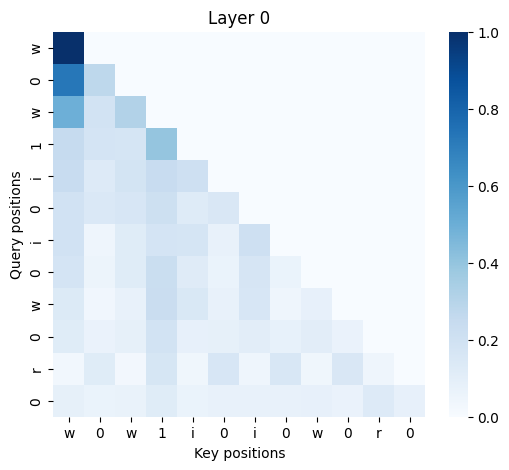

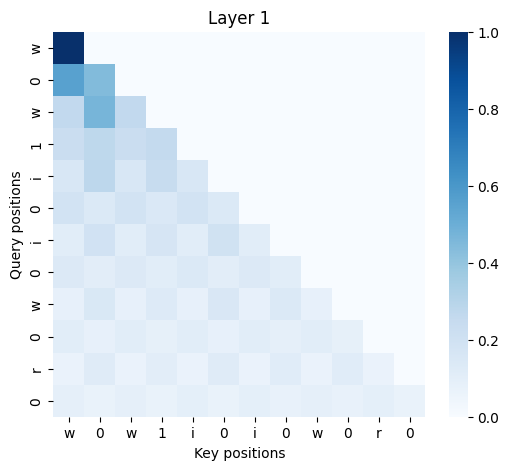

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_attention(attn_weights, token_labels=None):
    for layer_idx, layer_attn in enumerate(attn_weights):
        layer_attn = layer_attn[0].detach().numpy()
        plt.figure(figsize=(6, 5))
        sns.heatmap(layer_attn, annot=False, cmap="Blues", xticklabels=token_labels, yticklabels=token_labels)
        plt.title(f"Layer {layer_idx}")
        plt.xlabel("Key positions")
        plt.ylabel("Query positions")
            
        plt.show()

sentence = "w0w1i0i0w0r0"
ids = torch.tensor([[flip_flop_dict[c] for c in sentence]])  # [1, seq_len]
model.eval()
_ = model(ids, need_weights=True)
attn_weights = model.attn_weights
print(len(attn_weights))

# Visualize
visualize_attention(attn_weights, token_labels=list(sentence))

In [ ]:
def generate_sequence(model, id_to_token, max_len=10):
    model.eval()
    generated = [2, 1, 2, 1, 2, 1, 3]
    
    for _ in range(max_len):
        input_tensor = torch.tensor(generated, dtype=torch.long).unsqueeze(1)  # [seq_len, 1]
        
        with torch.no_grad():
            output = model(input_tensor)  # [seq_len, 1, vocab_size]
        
        next_token_logits = output[-1, 0]  # last token's logits: [vocab_size]
        next_token = torch.argmax(F.softmax(next_token_logits, dim=-1)).item()
        
        generated.append(next_token)

    # Convert token IDs back to characters
    decoded = [id_to_token[token_id] for token_id in generated if token_id in id_to_token]
    return decoded


id_to_token = {v: k for k, v in flip_flop_dict.items()}


generated_sentence = generate_sequence(model, id_to_token=id_to_token)

print("Generated flip-flop sentence:", "".join(generated_sentence))


Generated flip-flop sentence: w1w1w1r0i0i0i0i0i
